# Requirements

In [1]:
import numpy as np
import pandas as pd
import uuid
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from scipy.stats import pareto
from scipy.stats import gompertz

# Functions

In [2]:
def process_dataframe(df, num_percentiles=10, percentile_col='prod_perc'):
    # Filter for non-zero 'prod' values
    df = df[df["prod"] > 0].copy()
    # Calculate metrics
    length_nonzero = len(df)
    df["cnae_perc"] = 100 / length_nonzero
    # Calculate production percentages
    df["prod_perc"] = df["prod"] / df["prod"].sum() * 100
    # Sort DataFrame by 'prod_perc' in ascending order
    df = df.sort_values(by="prod_perc", ascending=True).reset_index(drop=True)
    # Step 1: Calculate the cumulative sum of 'cnae_perc' and create 'cnae_perc_cumsum'
    df["cnae_perc_cumsum"] = df["cnae_perc"].cumsum()
    # Step 2: Calculate the natural log of 'prod_perc' and create 'log_prod_perc'
    df["log_prod_perc"] = np.log(df["prod_perc"])
    # Step 3: Calculate the natural log of 'cnae_perc_cumsum' and create 'log_cnae'
    df["log_cnae_perc_cumsum"] = np.log(df["cnae_perc_cumsum"])
    # Step 4: Calculate the natural log of 'cnae_perc_cumsum' and create 'log_cnae'
    df["log_log_cnae_perc_cumsum"] = np.log(1 + np.abs(df["log_cnae_perc_cumsum"].min()) + df["log_cnae_perc_cumsum"])
    # Step 5: Normalize 'log_prod_perc' to a range of 0 to 100
    log_min, log_max = df["log_cnae_perc_cumsum"].min(), df["log_cnae_perc_cumsum"].max()
    df["log_log_cnae_perc_cumsum_norm"] = (df["log_cnae_perc_cumsum"] - log_min)*100 / (log_max - log_min)
    # Step 6: Normalize 'log_prod_perc' to a range of 0 to 100
    log_log_min, log_log_max = df["log_log_cnae_perc_cumsum"].min(), df["log_log_cnae_perc_cumsum"].max()
    df["log_log_cnae_perc_cumsum_norm"] = (df["log_log_cnae_perc_cumsum"] - log_log_min)*100 / (log_log_max - log_log_min)
    # Add percentiles using qcut and retrieve bin values
    if percentile_col in df.columns:
        df[f"{percentile_col}_percentile"], bins = pd.qcut(df[percentile_col], 
                                                            q=num_percentiles, 
                                                            labels=[f"P{i+1}" for i in range(num_percentiles)],
                                                            retbins=True
                                                         )
        # Add Lower and Upper Bounds for each percentile
        lower_bounds = bins[:-1]
        upper_bounds = bins[1:]
        percentile_to_bounds = {
            f"P{i+1}": (lower_bounds[i], upper_bounds[i]) for i in range(num_percentiles)
        }
        df["lower_bound_bin_interval"] = df[f"{percentile_col}_percentile"].map(lambda p: percentile_to_bounds[p][0])
        df["upper_bound_bin_interval"] = df[f"{percentile_col}_percentile"].map(lambda p: percentile_to_bounds[p][1])
        df[f"{percentile_col}_bin_interval"] = df[f"{percentile_col}_percentile"].map(
            lambda p: f"[{percentile_to_bounds[p][0]:.2f}, {percentile_to_bounds[p][1]:.2f}]"
        )
    else:
        raise ValueError(f"Column '{percentile_col}' not found in the DataFrame.")
    return df

def logarith_binning(df, prod_col='prod', cnae_perc_col='cnae_perc', growth = 1.1):
    # Ensure the DataFrame is sorted by production values
    df.sort_values(by=prod_col, inplace=True)
    # Binning
    prod_perc_bin = [df[prod_col].iloc[0]]  # Start with the smallest production value
    cnae_perc_bin = []

    while prod_perc_bin[-1] < df[prod_col].sum():
        next_bin = growth * prod_perc_bin[-1]
        prod_perc_bin.append(next_bin)
        cnae_perc_bin.append(df.loc[df[prod_col] > next_bin, cnae_perc_col].sum())

    # Cleaning Bins
    cnae_perc_bin = [x for x in cnae_perc_bin if x > 0]
    prod_perc_bin = prod_perc_bin[:len(cnae_perc_bin)]

    # Aligning Bins with the DataFrame
    bin_length = len(prod_perc_bin)
    df['prod_perc_bin'] = prod_perc_bin + [prod_perc_bin[-1]] * (len(df) - bin_length)
    df['cnae_perc_bin'] = cnae_perc_bin + [cnae_perc_bin[-1]] * (len(df) - len(cnae_perc_bin))

    return df


def synthetic_df(data, seed=42, size=1000):
    cnae = [str(uuid.uuid4()) for _ in range(n_obs)]
    return pd.DataFrame({'cnae': cnae, 'prod': data})

# Pipeline

## Data distribution

In [9]:
# Number of observations (sample size)
n_obs = 1000

# Data with pareto (power law) distribution
data = pareto.rvs(b=2.5, scale=1.0, size=n_obs)

# Data with gompertz distribution
#data = gompertz.rvs(c=0.5, scale=1.0, size=n_obs)

# Data with log normal distribution
# data = np.random.lognormal(mean=1, sigma=1, size=n_obs)

# Generate synthetic data
df = synthetic_df(data, seed=42, size=n_obs)
# Process dataframe
df = process_dataframe(df, num_percentiles=10, percentile_col='prod_perc')
# Perform logarithm binning
df = logarith_binning(df, prod_col='prod', cnae_perc_col='cnae_perc', growth = 1.1)

## Distribution plot of production values

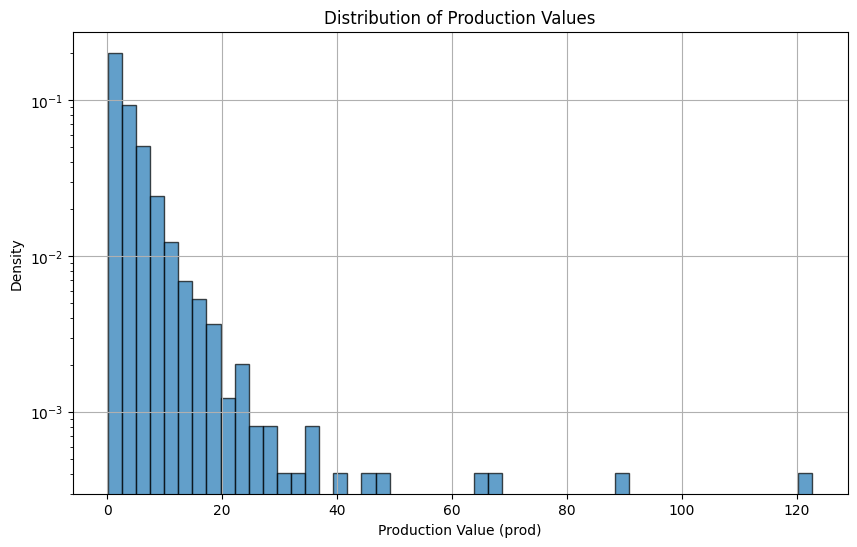

In [17]:
# Plot the distribution of 'prod'
plt.figure(figsize=(10, 6))
plt.hist(df['prod'], bins=50, density=True, alpha=0.7, edgecolor='black')
plt.xlabel('Production Value (prod)')
plt.ylabel('Density')
plt.title('Distribution of Production Values')
plt.grid(True)
plt.yscale('log')  # Log scale for better visualization of power law behavior
plt.show()

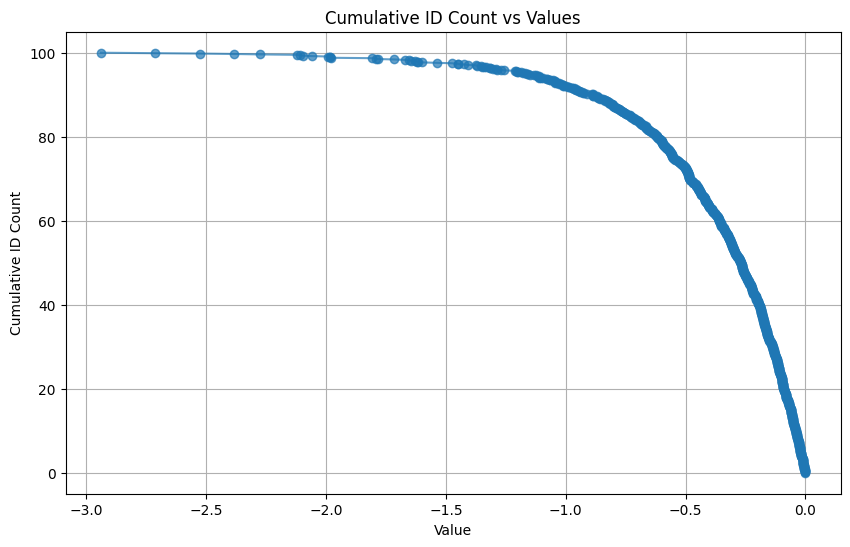

In [11]:
# Plot Cumulative ID Count vs Values
plt.figure(figsize=(10, 6))
plt.plot(-np.log(df['prod']), df['cnae_perc_cumsum'], marker='o', linestyle='-', alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Cumulative ID Count')
plt.title('Cumulative ID Count vs Values')
plt.grid(True)
plt.show()

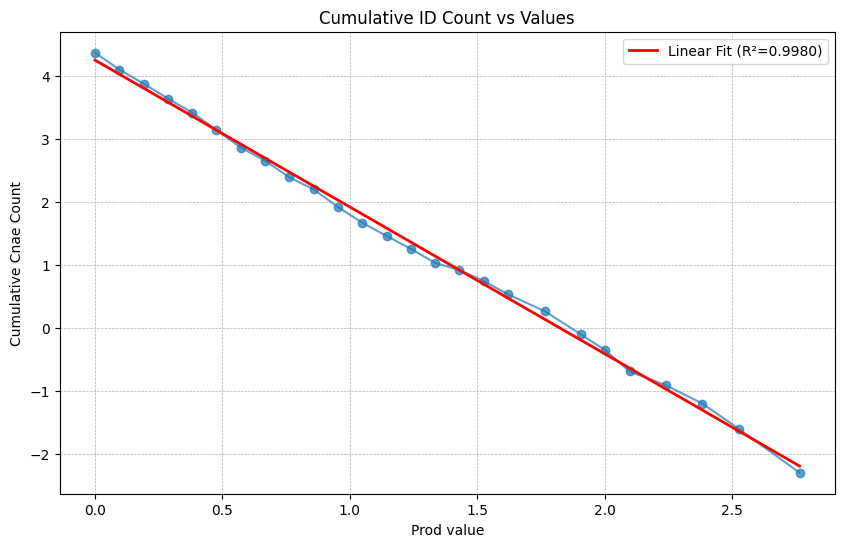

In [12]:
tb = df.groupby(['cnae_perc_bin']
                ).agg(prod = ('prod_perc_bin','mean')
                     ).reset_index()
#
x = np.array(tb['prod']).reshape(-1, 1)
y = np.array(tb['cnae_perc_bin']).reshape(-1, 1)
#
x = np.log(x)
y = np.log(y)
#
model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)
# Extract coefficients
slope = model.coef_[0][0]
intercept = model.intercept_[0]
# Calculate R-squared
r_squared = r2_score(y, y_pred)
        
# Plot Cumulative ID Count vs Values on a log-log scale
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-', alpha=0.7)
plt.plot(x, y_pred, label=f'Linear Fit (R²={r_squared:.4f})', color='red', linewidth=2)#
#
plt.xlabel('Prod value')
plt.ylabel('Cumulative Cnae Count')
plt.title('Cumulative ID Count vs Values')
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

# References

* https://www.kaggle.com/code/wuhong60909/nonlinear-regression-gompertz-model-2020-4-22
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gompertz.html#scipy.stats.gompertz
*